In [26]:
import torch
import torchvision
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [27]:
def create_data_generator(batch_size = 32, root = "data"):
    train_dataset = torchvision.datasets.MNIST(root = root,
                                             train = True,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
    test_dataset = torchvision.datasets.MNIST(root = root,
                                             train = False,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size = batch_size,
                                             shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size = batch_size,
                                             shuffle = False)
    return train_loader, test_loader

In [28]:
# class CharacterNetwork(nn.Module):
#     def __init__(self, hidden_dims = [128]):
#         super(CharacterNetwork, self).__init__()
#         self.network_dims = [28 * 28] + hidden_dims + [10]
#         self.layers = []
#         for i, dim in enumerate(self.network_dims[1:]):
#             prev_dim = self.network_dims[i]
#             dense = nn.Linear(in_features = prev_dim, out_features = dim, bias = True)
#             if i < len(self.network_dims[1:]) - 1:
#                 activation = nn.Sigmoid() # Hidden Layer
#             else:
#                 activation = nn.Softmax(dim=1) # Last Layer
#             self.layers += [dense, activation]

#         self.layers = nn.ModuleList(self.layers)

#     def forward(self, x):
#         # input x is [B, 1, 28, 28] where B is the batch size
#         size = x.size()
#         x = x.reshape(size[0], -1) # Flatten images
#         for layer in self.layers[:-1]:
#             x = layer(x)
#         if self.training == False:
#             x = self.layers[-1](x)
#         return x

class CharacterNetwork(nn.Module):
    def __init__(self, hidden_dims=[128,64,32,16]):
        super(CharacterNetwork, self).__init__()
        self.network_dims = [28 * 28] + hidden_dims + [10]
        self.layers = nn.ModuleList()

        for i in range(len(self.network_dims) - 1):
            in_dim = self.network_dims[i]
            out_dim = self.network_dims[i + 1]
            self.layers.append(nn.Linear(in_dim, out_dim))

            # Add activation for hidden layers only
            if i < len(self.network_dims) - 2:
                self.layers.append(nn.ReLU())

    def forward(self, x):
        # Input x is [B, 1, 28, 28] where B is the batch size
        x = x.view(x.size(0), -1)  # Flatten images
        for layer in self.layers[:-1]:
            x = layer(x)
        x = nn.functional.softmax(self.layers[-1](x), dim=1)  # Apply softmax to the final output
        return x

In [29]:
cuda = torch.cuda.is_available()
batch_size = 64
train_loader, test_loader = create_data_generator(batch_size)
model = CharacterNetwork()
print(model)

CharacterNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [30]:
def train(model, loader, n_epochs = 10, learning_rate = 0.001):
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda()

    optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate)


    # optim = torch.optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    log_losses = []
    log_accuracy = []
    model.train()

    for epoch in range(1, n_epochs + 1):
        for idx, (images, labels) in enumerate(loader):
            if cuda:
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)

            loss = loss_fn(outputs, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()



            predictions = torch.argmax(outputs, 1)
            accuracy = (predictions == labels).float().mean() * 100.

            loss = loss.item() # Convert to Python Scalar
            accuracy = accuracy.item() # Convert to Python Scalar
            log_losses.append(loss)
            log_accuracy.append(accuracy)

            if idx % 500 == 0:
                print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.2f. Accuracy: %0.2f" % (epoch, n_epochs, idx + 1, len(loader), loss, accuracy))

    return model, log_losses, log_accuracy

CharacterNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)
Epoch [1/10]. Iter [1/938]. Loss: 2.30. Accuracy: 7.81
Epoch [1/10]. Iter [501/938]. Loss: 1.74. Accuracy: 71.88
Epoch [2/10]. Iter [1/938]. Loss: 1.54. Accuracy: 95.31
Epoch [2/10]. Iter [501/938]. Loss: 1.52. Accuracy: 95.31
Epoch [3/10]. Iter [1/938]. Loss: 1.52. Accuracy: 93.75
Epoch [3/10]. Iter [501/938]. Loss: 1.50. Accuracy: 96.88
Epoch [4/10]. Iter [1/938]. Loss: 1.50. Accuracy: 93.75
Epoch [4/10]. Iter [501/938]. Loss: 1.49. Accuracy: 96.88
Epoch [5/10]. Iter [1/938]. Loss: 1.52. Accuracy: 93.75
Epoch [5/10]. Iter [501/938]. Loss: 1.51. Accuracy: 95.31
Epoch [6/10]. Iter [1/938]. Loss: 1.46. Accuracy: 100.00
Epoch [6/10]. Iter [501/938]. Loss:

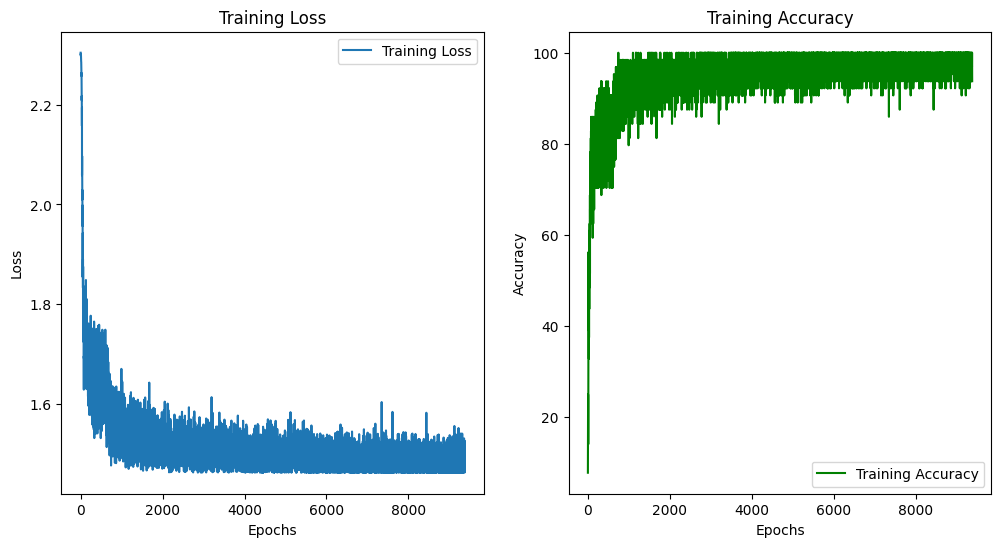

In [31]:
# Initialize the model
model = CharacterNetwork(hidden_dims=[128, 64, 32])  # Example with two hidden layers
print(model)

# Create data loaders
train_loader, test_loader = create_data_generator(batch_size=64)

# Train the model
model, losses, accuracies = train(model, train_loader, n_epochs=10, learning_rate=0.001)

# Save the trained model
torch.save(model.state_dict(), "CharacterModel.pth")

# Visualize training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(losses, label="Training Loss")
ax1.set_title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(accuracies, label="Training Accuracy", color="green")
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

In [32]:
def evaluate(model, loader):
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda()

    model.eval()
    model.load_state_dict(torch.load("CharacterModel.pth"))

    total_accuracy = 0.0
    for idx, (images, labels) in enumerate(test_loader):
        if cuda:
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)

        predictions = torch.argmax(outputs, 1)
        accuracy = (predictions == labels).float().mean() * 100.

        accuracy = accuracy.item() # Convert to Python Scalar

        total_accuracy += accuracy

        if idx % 200 == 0:
            print("Iter [%d/%d]. Accuracy: %0.2f" % (idx + 1, len(test_loader), accuracy))

    print("Final Accuracy: %0.2f" % (total_accuracy / len(test_loader)))

In [33]:
# Evaluate Model
evaluate(model, test_loader)

<ipython-input-32-79a823828ef8>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


Iter [1/157]. Accuracy: 100.00
Final Accuracy: 97.02


In [34]:
def nms(boxes, scores, threshold):
    if len(boxes) == 0:
        return []

    # Convert boxes to NumPy array
    boxes = np.array(boxes)

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort the bounding boxes by the confidence score
    indices = np.argsort(scores)[::-1]

    pick = []

    while len(indices) > 0:
        # Grab the index of the bounding box with the highest score
        i = indices[0]
        pick.append(i)

        # Compute the intersection over union (IoU)
        xx1 = np.maximum(x1[i], x1[indices[1:]])
        yy1 = np.maximum(y1[i], y1[indices[1:]])
        xx2 = np.minimum(x2[i], x2[indices[1:]])
        yy2 = np.minimum(y2[i], y2[indices[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        iou = (w * h) / (areas[i] + areas[indices[1:]] - w * h)

        # Remove the bounding boxes with IoU greater than the threshold
        indices = np.delete(indices, np.concatenate(([0], np.where(iou > threshold)[0] + 1)))

    return pick

def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check top 15 largest contours for character
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]


    target_contours = []
    img_res = []
    boxes = []
    scores = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :

            char_copy = np.zeros((60,40))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            char_copy[10:50, 10:30] = char

            boxes.append([intX, intY, intX+intWidth, intY+intHeight])
            scores.append(intWidth*intHeight)
            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    boxes = np.array(boxes)
    scores = np.array(scores)
    keep = nms(boxes, scores, 0.1)



    return [img_res[i] for i in keep], [boxes[i] for i in keep]

In [35]:

def detect_characters(image_path, model):
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda()
    model.eval()
    model.load_state_dict(torch.load("CharacterModel.pth"))

    image = cv2.imread(image_path)
    image = img_lp = cv2.resize(image, (333, 75))


    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_HEIGHT = img_binary_lp.shape[0]
    LP_WIDTH = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [0, LP_WIDTH/2, LP_HEIGHT/6, 3*LP_HEIGHT/3]


    # Get contours within cropped license plate
    char_list, boxes = find_contours(dimensions, img_binary_lp)
    for idx, char in enumerate(char_list):
        char = cv2.resize(char, (28, 28))
        char = torch.from_numpy(char).resize(1, 1, 28, 28).float()
        if cuda:
            char = char.cuda()

        outputs = model(char)

        pred = torch.argmax(outputs, 1)[0].item()

        x1, y1, x2, y2 = boxes[idx]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
        image = cv2.putText(image, f'{pred}', (x1+2, y1+12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv2.LINE_AA)

    plt.figure()
    plt.imshow(image[..., ::-1])
    plt.axis("off")


<ipython-input-35-2d0427419404>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth"))


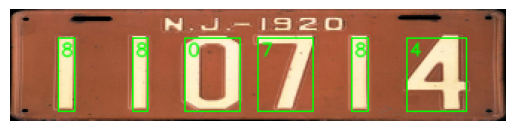

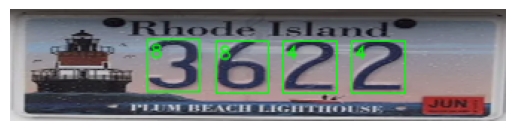

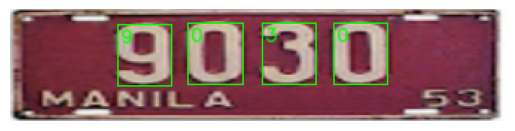

In [36]:
detect_characters("data/example1.jpeg", model)
detect_characters("data/example2.png", model)
detect_characters("data/example3.png", model)